# Implied volatility surface construction from US crude oil ETF option chains

In this notebook we build and visualize an **implied volatility surface** for **USO** (United States Oil Fund), an ETF designed to track the price of **crude oil**.  
We download option quotes across multiple **expiries** and **strikes**, compute the **Black–Scholes implied volatility** for each quote by numerically inverting the pricing formula, and then interpolate the results to obtain a smooth **IV surface**.

**Important note:** USO options are typically **American-style**, but we compute **Black–Scholes implied volatilities** as a standardized way to represent market option prices.

---

## Black–Scholes European Call Price

The Black–Scholes price of a **European call option** is:

$$
C = S_0 e^{-qT}N(d_1) - K e^{-rT}N(d_2)
$$

with

$$
d_1 = \frac{\ln(S_0/K) + (r - q + \tfrac{1}{2}\sigma^2)T}{\sigma\sqrt{T}},
$$



$$
d_2 = d_1 - \sigma\sqrt{T}
$$

### Variables

- $S_0$: current underlying price (spot)  
- $K$: strike price  
- $T$: time to maturity (in years)
- $r$: Risk-free rate  
- $q$: Dividend yield   
- $\sigma$: volatility of the underlying stock (annualized)  


In [13]:
from jax.scipy.stats import norm as jnorm
import jax.numpy as jnp
from jax import grad

import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timezone

## What is Implied Volatility?

**Implied volatility (IV)** is the value of volatility $\sigma$ that makes an option pricing model (e.g., Black–Scholes) match the **observed market price** of an option.

In other words, instead of *assuming* a volatility and computing a theoretical option price, we **invert** the pricing model: we take the market option price as input and solve for the volatility that satisfies

$$
P_{\text{theory}}(S, K, T, r, \sigma, q) = P_{\text{actual}}.
$$

## Newton - Rhapson Method
The Newthon method to find the zeros of a function $f(x)$ consists on calculating

$$
x^g_{(n+1)} = x^g_n - \frac{f(x^g_n)}{f'(x^g_n)}
$$

with $x^g_n$ being the guess of the volatility at iteration $n$.

We can solve for the implied volatility with this simple iterative routine (Newton–Raphson). The idea is to adjust $\sigma$ until the Black–Scholes theoretical price matches the observed market price.

### Algorithm (Newton–Raphson for Implied Volatility)

1. **Initialize** a starting guess for the volatility, $\sigma_0$.
2. **Compute the loss function**:
   $$
   \mathcal{L}(\sigma_n) = P_{\text{theory}}(\sigma_n) - P_{\text{actual}}.
   $$
3. **Check convergence**:
   $$
   |\mathcal{L}(\sigma_n)| < \epsilon
   $$
   - If **true**, **stop** and return $\sigma_n$.
   - If **false**, continue.
4. **Compute the gradient** with respect to volatility:
   $$
   \frac{\partial \mathcal{L}}{\partial \sigma}(\sigma_n).
   $$
5. **Update volatility** using Newton–Raphson:
   $$
   \sigma_{n+1}
   =
   \sigma_n
   -
   \frac{\mathcal{L}(\sigma_n)}
   {\frac{\partial \mathcal{L}}{\partial \sigma}(\sigma_n)}.
   $$
6. **Repeat** steps 2–5 until convergence or until reaching the maximum number of iterations, $N_{\text{iter}}$.


In [14]:
def black_scholes_price(S, K, T, r, sigma, q=0.0, otype="call"):
    # Safety eps to avoid division by zero
    eps = 1e-12
    T = jnp.maximum(T, eps)
    sigma = jnp.maximum(sigma, eps)

    d1 = (jnp.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * jnp.sqrt(T))
    d2 = d1 - sigma * jnp.sqrt(T)

    if otype == "call":
        return S * jnp.exp(-q * T) * jnorm.cdf(d1) - K * jnp.exp(-r * T) * jnorm.cdf(d2)
    else:
        return K * jnp.exp(-r * T) * jnorm.cdf(-d2) - S * jnp.exp(-q * T) * jnorm.cdf(-d1)


def loss(S, K, T, r, sigma_guess, price, q=0.0, otype="call"):
    theoretical_price = black_scholes_price(S, K, T, r, sigma_guess, q, otype)
    return theoretical_price - price


# Derivative of loss w.r.t sigma_guess
loss_grad = grad(loss, argnums=4)

In [15]:
def solve_for_iv(S, K, T, r, price, sigma_guess=0.8, q=0, otype="call",
                 N_iter=20, epsilon=.001, verbose=True):

    sigma = float(sigma_guess)

    # safeguards
    sigma_min, sigma_max = 1e-6, 5.0
    max_step = 0.5        # cap the Newton update size
    damping = 0.5         # damp Newton step (0.3–0.8 are common)
    vega_floor = 1e-10    # avoid division by tiny gradient

    for i in range(N_iter):
        if verbose:
            print("\nIteration: ", i)

        # keep sigma in a reasonable range
        sigma = float(np.clip(sigma, sigma_min, sigma_max))

        loss_val = float(loss(S, K, T, r, sigma, price, q, otype))

        if verbose:
            print("Current Error in Theoretical vs Market Price:")
            print(loss_val)

        if abs(loss_val) < epsilon:
            break

        loss_grad_val = float(loss_grad(S, K, T, r, sigma, price, q, otype))

        # if gradient is too small, Newton becomes unstable
        if (not np.isfinite(loss_grad_val)) or abs(loss_grad_val) < vega_floor:
            if verbose:
                print("Gradient too small / not finite (Vega ~ 0). Stopping.")
            break

        step = loss_val / loss_grad_val

        # cap step to avoid exploding updates
        step = float(np.clip(step, -max_step, max_step))

        # damped Newton update
        sigma = sigma - damping * step

        # if sigma becomes non-finite, stop
        if not np.isfinite(sigma):
            if verbose:
                print("Sigma became non-finite. Stopping.")
            break

    return sigma


# Download and pre-process of the data

A couple of practical choices for the data cleaning:

- I build the **mid** price as `(bid + ask)/2`, and fall back to `lastPrice` when bid/ask are missing or zero.  
- I drop **expired** options and I keep only contracts with non‑zero **volume** and **open interest**.  
- I also discard quotes whose `lastTradeDate` is older than ~2 days to be coherent with the time price of the stock.


In [16]:
# Download USO today spot price
ticker = "USO"
tk = yf.Ticker(ticker)
df = tk.history(period="1d")

# Use last price as current price
S = df["Close"].iloc[-1]

display(df)

print("Ticker: ", ticker)
print("Spot price (last close)", S)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2026-02-13 00:00:00-05:00,76.120003,76.720001,75.660004,76.220001,6169000,0.0,0.0,0.0


Ticker:  USO
Spot price (last close) 76.22000122070312


In [17]:
asof = datetime.now(timezone.utc)
options = []

# this finds all the available expiries
expiries = tk.options

for expire in expiries:
    chain = tk.option_chain(expire)

    calls = chain.calls.copy()
    puts  = chain.puts.copy()

    calls["type"] = "call"
    puts["type"]  = "put"

    calls["expiry"] = pd.to_datetime(expire, utc=True)
    puts["expiry"]  = pd.to_datetime(expire, utc=True)

    df = pd.concat([calls, puts], ignore_index=True)

    # define the option price as the mid between bid and ask
    df["option_price"] = (df["bid"] + df["ask"]) / 2

    # if bid or ask = 0 then use lastPrice
    df.loc[(df["bid"] <= 0) | (df["ask"] <= 0), "option_price"] = df.loc[(df["bid"] <= 0) | (df["ask"] <= 0), "lastPrice"]

    # Time to maturity in years (ACT/365), as-of today
    df["T"] = (df["expiry"] - asof).dt.total_seconds() / (365.0 * 24 * 3600)

    # Keep only non-expired options
    df = df[df["T"] > 0].copy()

    # filter out rows with volume = 0 and openInterest = 0
    df = df[(df["volume"] > 0) & (df["openInterest"] > 0)].copy()

    # STRICT: keep only rows with lastTradeDate within 2 days
    df["lastTradeDate"] = pd.to_datetime(df["lastTradeDate"], utc=True, errors="coerce")
    age_days = (pd.Timestamp.utcnow() - df["lastTradeDate"]) / pd.Timedelta(days=1)
    df = df[age_days <= 2].copy()

    #compute moneyness
    df["moneyness (S/K)"] = S / df["strike"]

    options.append(df)

dataframe = pd.concat(options, ignore_index=True)

cols_keep = [
    "type", "expiry", "T",
    "strike", "option_price",
    "bid", "ask",
    "volume", "openInterest",
    "lastTradeDate",
    "moneyness (S/K)"
]

dataframe = dataframe[cols_keep].copy()
display(dataframe)



,type,expiry,T,strike,option_price,bid,ask,volume,openInterest,lastTradeDate,moneyness (S/K)
0,call,2026-02-18 00:00:00+00:00,0.009210,69.0,7.050,5.15,8.95,5.0,6,2026-02-13 19:01:30+00:00,1.104638
1,call,2026-02-18 00:00:00+00:00,0.009210,71.0,5.225,3.40,7.05,5.0,11,2026-02-13 16:20:44+00:00,1.073521
2,call,2026-02-18 00:00:00+00:00,0.009210,72.0,4.350,4.05,4.65,20.0,162,2026-02-13 19:06:08+00:00,1.058611
3,call,2026-02-18 00:00:00+00:00,0.009210,73.0,3.375,3.25,3.50,6.0,30,2026-02-13 19:06:32+00:00,1.044110
4,call,2026-02-18 00:00:00+00:00,0.009210,74.0,2.500,2.44,2.56,17.0,128,2026-02-13 20:53:40+00:00,1.030000
...,...,...,...,...,...,...,...,...,...,...,...
513,call,2028-01-21 00:00:00+00:00,1.932497,81.0,14.375,13.40,15.35,2.0,73,2026-02-13 20:58:19+00:00,0.940988
514,call,2028-01-21 00:00:00+00:00,1.932497,83.0,12.825,11.40,14.25,1.0,24,2026-02-12 16:20:11+00:00,0.918313
515,call,2028-01-21 00:00:00+00:00,1.932497,100.0,7.400,5.95,8.85,8.0,191,2026-02-13 19:11:04+00:00,0.762200
516,call,2028-01-21 00:00:00+00:00,1.932497,120.0,4.375,3.50,5.25,15.0,43,2026-02-12 16:56:31+00:00,0.635167


# Implied volatility calculation

In [18]:
ivs = []
moneyness = []
dtes = []
# risk free interest rate
r = .045


calls = dataframe[dataframe["type"] == "call"].copy()

for idx, row in calls.iterrows():
    K = row["strike"]
    T = row["T"]
    market_price = row["option_price"]


    iv = solve_for_iv(S, K, T, r, market_price, verbose=False, otype="call")

    ivs.append(float(iv))
    moneyness.append(float(row["moneyness (S/K)"]))
    dtes.append(float(T))

### Visualisation

For the surface plot we use **Matplotlib**


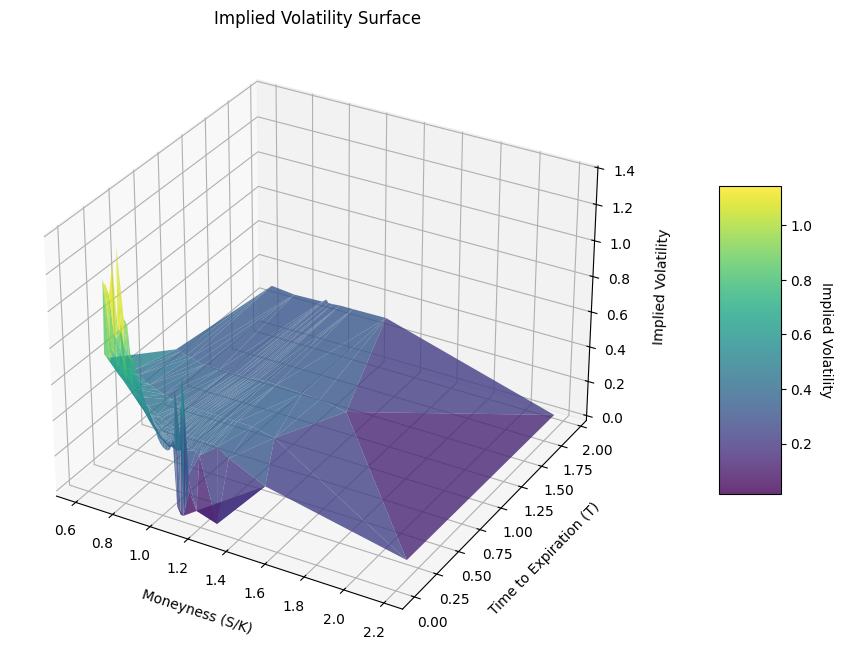

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure(figsize=(12, 8), dpi=100)
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_trisurf(
    moneyness, dtes, ivs,
    cmap="viridis",
    linewidth=0.1,
    antialiased=True,
    alpha=0.8
)

cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, pad=0.1)
cbar.set_label("Implied Volatility", rotation=270, labelpad=15)

ax.set_xlabel("Moneyness (S/K)", labelpad=10)
ax.set_ylabel("Time to Expiration (T)", labelpad=10)
ax.set_zlabel("Implied Volatility", labelpad=10)

plt.title("Implied Volatility Surface")
plt.show()
